# Assignment-8

Author: Tarang Ranpara (201011057)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# downloading the dataset 
!gdown https://drive.google.com/uc?id=18l6IwSqavnqtLQpVnrRqOugZf9XkhEAN

Downloading...
From: https://drive.google.com/uc?id=18l6IwSqavnqtLQpVnrRqOugZf9XkhEAN
To: /content/jigsaw-toxic-comment-classification-challenge.zip
100% 55.2M/55.2M [00:00<00:00, 151MB/s]


In [3]:
# unzipping
!unzip /content/jigsaw-toxic-comment-classification-challenge.zip
!unzip /content/train.csv.zip

Archive:  /content/jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           
Archive:  /content/train.csv.zip
  inflating: train.csv               


In [2]:
# train data 
df = pd.read_csv("/content/train.csv")

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# adding 'none' label for a scenario where record is classified in neither of the given classes 
df['none'] = 1 - df[labels].max(axis=1)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [5]:
df['none'] = 1 - df[labels].max(axis=1)

# filling null with <unknown> token 
df['comment_text'].fillna('<unknown>',inplace=True)

In [6]:
# updated labels
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'none']

In [7]:
# maximum sequence length of input (i.e. every sequence will be padded upto this length)
max_sequence_length = 128

# tokenizer - to split text sequence into tokens 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['comment_text'])
sequences = tokenizer.texts_to_sequences(df['comment_text'])

# to pad the sequences upto max length 
pad_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

In [11]:
def build_model(vocab_size, max_sequence_length, n_class):
    input = Input(shape=(max_sequence_length,))

    # step-1: calculating embedding of input sequenes
    # transforms: (batch_size x max_seq_len) -> (batch size x max_seq_len x embedding_dim)
    
    # step-2: applying bidirectional lstm
    # transforms: (batch_size x 2*16)
    x = Bidirectional(LSTM(16))(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_sequence_length, embeddings_initializer='random_normal')(input))
    x = Dropout(0.5)(x)

    # step-3: dense layer: 32 -> 16
    x = Dense(16, activation='relu')(x)

    # step-4: dense layer: 16 -> 7
    output = Dense(n_class, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=input, outputs=output)

    # loss:  binary cross entropy
    # optimizer: Adam  
    model.compile (optimizer='adam', 
                   loss="binary_crossentropy", 
                   metrics=['accuracy', 'Precision', 'Recall'])
    
    return model

In [12]:
vocab_size = len(tokenizer.word_index) + 1
n_class = len(labels)
model = build_model(vocab_size, max_sequence_length, n_class)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 128, 64)           13461632  
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 7)                 119       
                                                           

In [13]:
batch_size = 1024
epochs = 20

# fitting the model 
history = model.fit(pad_sequences, 
                    y=df[labels],
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_split=0.1,
                    shuffle = True
                    )

Epoch 1/20
141/141 [==============================] - 16s 80ms/step - loss: 0.3426 - accuracy: 0.6103 - precision: 0.5283 - recall: 0.7960 - val_loss: 0.1395 - val_accuracy: 0.8979 - val_precision: 0.8968 - val_recall: 0.8027
Epoch 2/20
141/141 [==============================] - 10s 71ms/step - loss: 0.1057 - accuracy: 0.9290 - precision: 0.9092 - recall: 0.8629 - val_loss: 0.0732 - val_accuracy: 0.9520 - val_precision: 0.9260 - val_recall: 0.9109
Epoch 3/20
141/141 [==============================] - 10s 70ms/step - loss: 0.0674 - accuracy: 0.9610 - precision: 0.9358 - recall: 0.9208 - val_loss: 0.0662 - val_accuracy: 0.9601 - val_precision: 0.9394 - val_recall: 0.9198
Epoch 4/20
141/141 [==============================] - 10s 70ms/step - loss: 0.0559 - accuracy: 0.9695 - precision: 0.9462 - recall: 0.9320 - val_loss: 0.0637 - val_accuracy: 0.9590 - val_precision: 0.9352 - val_recall: 0.9220
Epoch 5/20
141/141 [==============================] - 10s 69ms/step - loss: 0.0493 - accuracy: 0

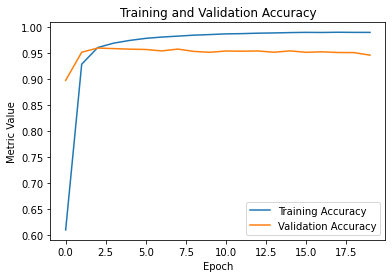

In [14]:
# plotting training and validation accuracy 
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

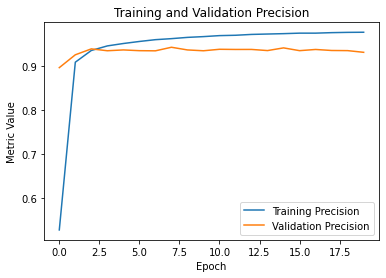

In [15]:
# plotting training and validation precision 
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

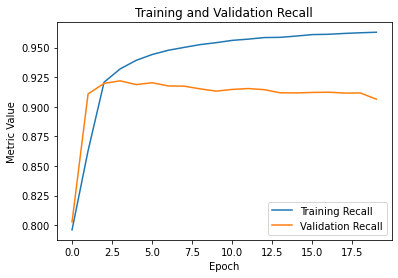

In [16]:
# plotting training and validation recall 
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

In [17]:
# defining f1 score 
def f1(prec, recall):
    return (2 * prec * recall) / (prec + recall)

In [21]:
# final scores 
pd.DataFrame(dict({
    'precision': [history.history["precision"][-1], history.history["val_precision"][-1]], 
    'recall': [history.history["recall"][-1], history.history["val_recall"][-1]], 
    'f1': [f1(history.history["precision"][-1],history.history["recall"][-1]), f1(history.history["val_precision"][-1],history.history["val_recall"][-1])], 
}), index = ['train', 'validation'])

,precision,recall,f1
train,0.977203,0.962985,0.970042
validation,0.931621,0.906412,0.918844
